# Case 4: Resolviendo la ecuación de Poisson con PINNs

## Introducción

En este cuaderno, exploraremos cómo implementar una Red Neuronal Informada por la Física (PINN) utilizando PyTorch para resolver una ecuación diferencial específica. Las PINNs integran leyes físicas en la estructura de una red neuronal, permitiéndonos resolver problemas de ingeniería y física de manera eficiente.



In [76]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Marco Matemático de las Redes Neuronales Informadas por la Física (PINNs)

### 1. Formulación del Problema

Consideremos una Ecuación Diferencial Parcial (EDP) general expresada como:
$$ \mathcal{L}(u; x) = 0, $$
donde $ \mathcal{L} $ es un operador diferencial, $ u $ es la solución de la EDP, y $ x $ denota las variables espaciales (y posiblemente temporales).

Las condiciones de frontera y condiciones iniciales se pueden representar como:
$ \mathcal{B}(u; x) = g(x), \quad \text{para } x \in \partial\Omega, $
donde $ \mathcal{B} $ es un operador de frontera y $ \Omega $ es el dominio de interés.

### 2. Aproximación mediante Redes Neuronales

Una red neuronal $\hat{u}_\theta(x) $, parametrizada por pesos y sesgos $ \theta $, se utiliza para aproximar la solución $ u(x)$. La red se entrena para minimizar una función de pérdida que encapsula tanto la adherencia a la EDP como la precisión respecto a las condiciones de frontera dadas.

### 3. Función de Pérdida

La función de pérdida en las PINNs típicamente combina dos componentes:

- **Residual de la EDP**: Este es el residual de sustituir la aproximación de la red neuronal en la EDP:
  $$ R_{\text{PDE}}(\theta) = \|\mathcal{L}(\hat{u}_\theta; x) \|_2^2, $$
  donde la norma es generalmente una norma $L^2$ tomada sobre el dominio.

- **Residual de la Condición de Frontera**: Este componente asegura que la solución se adhiera a las condiciones de frontera:
  $$ R_{\text{BC}}(\theta) = \| \mathcal{B}(\hat{u}_\theta; x) - g(x) \|_2^2, $$
  donde la norma se evalúa sobre la frontera $ \partial\Omega $.

La función de pérdida total es una suma ponderada de estos residuos:
$$ J(\theta) = \lambda_1 R_{\text{PDE}}(\theta) + \lambda_2 R_{\text{BC}}(\theta), $$
donde $ \lambda_1 $ y $ \lambda_2 $ son factores de ponderación que pueden ajustarse basándose en la importancia relativa de cada componente.

### 4. Proceso de Entrenamiento

El entrenamiento implica encontrar los parámetros óptimos $ \theta $ que minimizan la función de pérdida \( J(\theta) \). Esto se realiza generalmente utilizando técnicas de optimización basadas en gradientes, como el descenso de gradiente estocástico, Adam, etc. Los gradientes se calculan usando diferenciación automática, una característica clave soportada por marcos de trabajo como TensorFlow y PyTorch.

### Consideraciones y Desafíos Matemáticos

- **Complejidad y No Linealidad**: Los operadores diferenciales involucrados pueden ser altamente no lineales y complejos, lo que plantea desafíos significativos tanto en la modelación precisa de los operadores dentro de la red neuronal como en asegurar la convergencia del proceso de entrenamiento.

- **Espacios de Alta Dimensión**: Para problemas que involucran EDPs de alta dimensión, la maldición de la dimensionalidad puede convertirse en un problema significativo. Estrategias como la reducción de la dimensionalidad o arquitecturas de red especializadas (e.g., redes neuronales convolucionales para datos espaciales) son a menudo necesarias.

- **Balance de Componentes de Pérdida**: Elegir valores apropiados para $ \lambda_1 $ y $ \lambda_2 $ es crucial. Un equilibrio inapropiado puede llevar a un modelo que se adhiere a la física pero se ajusta pobremente a los datos, o viceversa.

- **Generalización vs. Sobreajuste**: Como todos los modelos de aprendizaje automático, las PINNs enfrent

<img src="pinn_schematic.jpg" width="800" height="600" alt="Description of Image">
Créditos: doi:10.3390/en16093820

## Un ejemplo básico ...

### Ecuación Diferencial de Poisson

Consideramos la ecuación de Poisson unidimensional:

$$ \frac{d^2u}{dx^2} = -\pi^2 \sin(\pi x) $$

con condiciones de frontera $u(0) = 0$ y $u(1) = 0$.

### Solución Analítica

La solución analítica para esta ecuación es:

$$u(x) = \sin(\pi x)$$

Utilizaremos esta solución para comparar con los resultados obtenidos por nuestra red neuronal.


## Arquitectura de la Red Neuronal

La red neuronal consiste en varias capas densas y utiliza la función de activación Tangente Hiperbólica (Tanh). Este tipo de arquitectura es común en las PINNs debido a su capacidad para modelar respuestas no lineales.


## Implementación en PyTorch

A continuación, definimos la clase `PINN`, que construye nuestra red neuronal. Utilizamos PyTorch para definir la estructura y la función de pérdida informada por la física.


In [77]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.net(x)


## Entrenamiento del Modelo

El modelo se entrena utilizando un conjunto de datos que simula las condiciones del problema, incluyendo las condiciones de frontera. El proceso de entrenamiento busca minimizar la pérdida, que incluye términos para la precisión de la solución y el cumplimiento de la ecuación diferencial.


In [78]:
def physics_informed_loss(model, x):
    u = model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = u_xx + np.pi**2 * torch.sin(np.pi * x)
    return torch.mean(f**2)


In [79]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x = torch.linspace(0, 1, 100, requires_grad=True).reshape(-1, 1)
x_bc = torch.tensor([0, 1], dtype=torch.float32).reshape(-1, 1)

epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = physics_informed_loss(model, x)
    u_bc = model(x_bc)
    loss_bc = torch.mean((u_bc - 0)**2)
    total_loss = loss + loss_bc
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss.item()}')


Epoch 0, Loss: 48.728050231933594
Epoch 100, Loss: 0.0021841914858669043
Epoch 200, Loss: 0.0009095733985304832
Epoch 300, Loss: 0.00044710864312946796
Epoch 400, Loss: 0.00028879332239739597
Epoch 500, Loss: 0.00024065133766271174
Epoch 600, Loss: 0.0002215830609202385
Epoch 700, Loss: 0.0002083051804220304
Epoch 800, Loss: 0.00019626819994300604
Epoch 900, Loss: 0.0001847791572799906


## Visualización y Comparación de Resultados

Visualizamos la solución de la red y la comparamos con la solución analítica para evaluar el rendimiento de nuestro modelo.


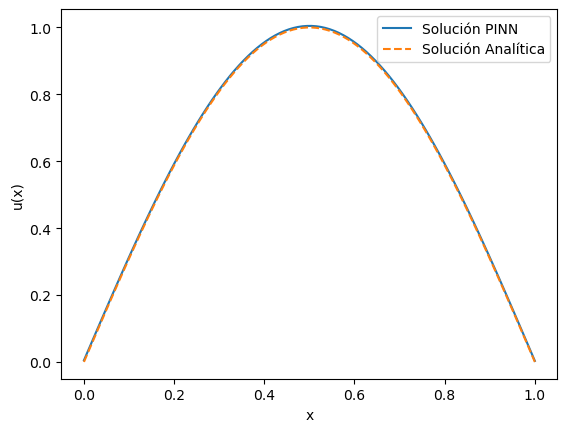

In [80]:
x_eval = torch.linspace(0, 1, 100).reshape(-1, 1)
with torch.no_grad():
    u_pred = model(x_eval).reshape(-1).numpy()
x_eval = x_eval.reshape(-1).numpy()
u_exact = np.sin(np.pi * x_eval)

plt.plot(x_eval, u_pred, label='Solución PINN')
plt.plot(x_eval, u_exact, label='Solución Analítica', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.show()

## Conclusiones

Discutimos el rendimiento de la red, posibles aplicaciones futuras de las PINNs, y cómo este enfoque puede ser extendido a problemas más complejos.
